In [1]:
import jax
import jax.numpy as jnp
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from LombScargle import periodogram
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('../img/style.mplstyle')


def get_y(key, num, spread= 3., mixture = 1.):
    
    y_fixed = jnp.array([0.8635225711753599, 3.0004414364876055, 1.7112635323263894, 0.4661426878500358, 0.3608930521377926, 0.32117450191005287, 0.27656221811276294]) # their average should be 1
    y_random = jax.random.uniform(key, shape= (num, ), minval= 1./jnp.sqrt(spread), maxval= jnp.sqrt(spread))
    
    y = jnp.concatenate((y_fixed, y_random))
    
    return mixture * y + (1-mixture) # if mixture=1, the optimal y are returned, if mixture = 0, the true template is returned


def get_y_old(key, num, spread= 3.):
    return jax.random.uniform(key, shape= (num, ), minval= 1./jnp.sqrt(spread), maxval= jnp.sqrt(spread))
    

def null_signal_template(y):
    """null template with randomized period
        num: the number of random periods to be generated. Should be larger than T / minimal period that will be later used with the template
        spread = b/a"""
    
    
    def get_periods(freq, total_time):
        """Convert the y to the periods of cycles.
            cycles is a float = freq * total time"""
        cycles= freq * total_time
        cycles_frac, _cycles_integer = jnp.modf(cycles)
        cycles_integer = _cycles_integer.astype(int)

        weights = (jnp.arange(1, len(y)+1) <= cycles).astype(float)  
        weights = weights.at[cycles_integer].set(cycles_frac)
        return total_time * y / jnp.sum(y * weights)


    def temp(_t, freq):
        t = _t - jnp.min(_t)
        periods = get_periods(freq, jnp.max(t)) 
        grid = jnp.cumsum(periods)
        grid_paddled = jnp.insert(grid, 0, 0.)
        which_period = jnp.searchsorted(grid, t)
        x = (t - grid_paddled[which_period]) / periods[which_period]
        return jnp.sin(2 * jnp.pi * x), jnp.cos(2 * jnp.pi * x)
    
    return temp

    
    
def _mainn(key, cycles, get_y_func):
    """period = 1, phase = 0, without loss of generality"""
    
    # data = unmodified template
    time = jnp.linspace(0, cycles, (int)(cycles * 20))
    data = jnp.sin(2 * jnp.pi * time)
    c= jnp.log10(5.)
    freq = jnp.logspace(-c, c, 1000)
    
    # scan with the modified template
    
    y = get_y_func(key, 500)
    temp = null_signal_template(y)
    periodogram_modified = periodogram.lomb_scargle(time, data, floating_mean= False, temp_func= temp)
    score_modified = jnp.max(jax.vmap(periodogram_modified)(freq)[0])

    score_og = periodogram.lomb_scargle(time, data, floating_mean= False)(1.)[0]
    
    return score_modified / score_og


reps = 50
key = jax.random.key(42)
keys = jax.random.split(key, reps)

mainn = lambda cycles, get_y_func: jax.vmap(_mainn, (0, None, None))(keys, cycles, get_y_func)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
cycles = np.logspace(np.log10(2.), jnp.log10(15), 50)
scores = np.array([mainn(c, get_y) for c in cycles])
scores_mix5 = np.array([mainn(c, lambda k, n: get_y(k, n, mixture= 0.5)) for c in cycles])
scores_mix2 = np.array([mainn(c, lambda k, n: get_y(k, n, mixture= 0.2)) for c in cycles])
scores_old = np.array([mainn(c, get_y_old) for c in cycles])

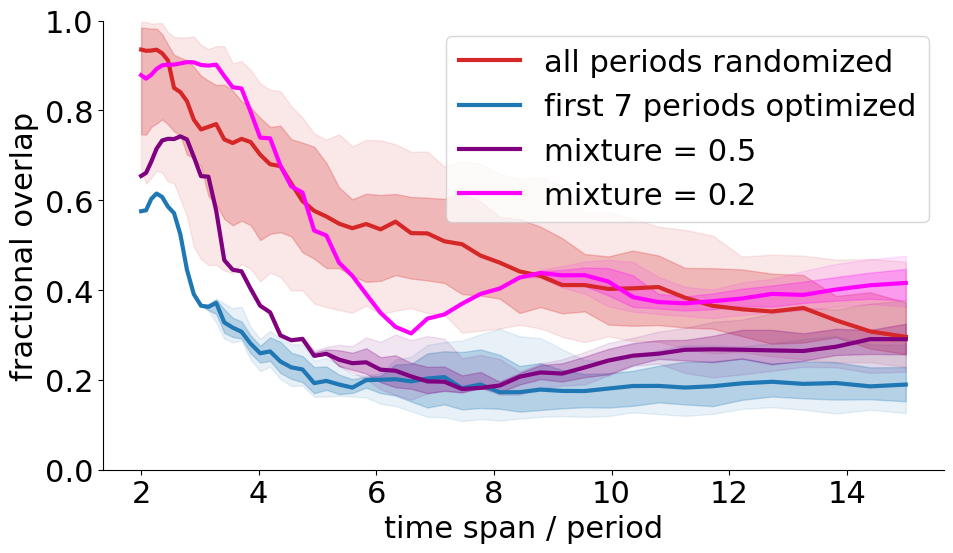

In [5]:
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['font.size'] = 22

plt.figure(figsize= (10, 6))

plots = (
    (scores_old, 'tab:red', 'all periods randomized'),
    (scores, 'tab:blue', 'first 7 periods optimized'),
    (scores_mix5, 'purple', 'mixture = 0.5'),
    (scores_mix2, 'magenta', 'mixture = 0.2'),
)
for plot in plots:
    s, color, label = plot
    plt.plot(cycles, np.median(s, axis=1), lw= 3, color= color, label= label)
    for q in [0.25, 0.1]:
        plt.fill_between(cycles, np.quantile(s, q, axis=1), np.quantile(s, 1-q, axis=1), alpha= q, color= color)

plt.xlabel('time span / period')
plt.ylabel('fractional overlap')
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
#plt.savefig('../img/overlap.png')
plt.show()

In [ ]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
for i in range(len(params)):
    plt.hist(r[i], bins = 20, density= True, alpha = 0.5, label= 'cycles = {0}, b/a = {1}'.format(*params[i]))

plt.xlabel('score(modified) / score(periodic)')
plt.ylabel('density')
plt.xlim(0, 1)
plt.legend()

plt.subplot(1, 2, 2)
for i in range(len(params)):
    plt.hist(r[i], bins = 2000, density= True, cumulative = -1, histtype= 'step', label= 'cycles = {0}, b/a = {1}'.format(*params[i]), lw = 2)

plt.xlabel('r = score(modified) / score(periodic)')
plt.ylabel('P(R > r)')
plt.xlim(0, 1)

plt.show()

In [ ]:
params = [3, 3.]
rr = np.array(main(*params))
plt.figure(figsize = (15, 5))
plt.suptitle('cycles = {0}, b/a = {1}'.format(*params))

plt.subplot(1, 2, 1)
plt.hist(rr, bins = 20, density= True)
plt.xlabel('score(modified) / score(periodic)')
plt.ylabel('density')
plt.xlim(0, 1)

plt.subplot(1, 2, 2)
plt.hist(rr, bins = 1000, density= True, cumulative = -1, histtype= 'step')
plt.xlabel('r = score(modified) / score(periodic)')
plt.ylabel('P(R > r)')
plt.xlim(0, 1)

plt.show()

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
cycles = np.logspace(np.log10(3.), np.log10(100), 10)
spread = np.logspace(np.log10(1.), np.log10(30.), 10)

c, s = np.meshgrid(cycles, spread)
r = np.load('r.npy')

plt.figure(figsize = (15, 7))

plt.subplot(1, 2, 1)
plt.title('P(R > r) = 0.5', y = 1.05)
plt.contourf(c, s, np.median(r, axis = -1).T, levels = np.arange(11) * 0.1, cmap= 'Greys')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('cycles')
plt.ylabel('b / a')

plt.subplot(1, 2, 2)
n = r.shape[-1] * 9 // 10
R = np.sort(r, axis= -1)[:, :, n].T
plt.title('P(R > r) = 0.1', y = 1.05)
plt.contourf(c, s, R, levels = np.arange(11) * 0.1, cmap= 'Greys')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('cycles')
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
from quasars.prep import ids

num_quasars = 35383
keys = jax.random.split(jax.random.PRNGKey(42), num_quasars)


def _reduction(time, mag_err, freq, period, a, temp_func):
    freq_injected = 1./period
    signal = periodogram.fit(time, freq_injected, a)

    # score with the original template
    score0, _ = periodogram.lomb_scargle(time, signal, True, mag_err)(freq_injected)
    
    # score with the modified template
    score, amps = jax.vmap(periodogram.lomb_scargle(time, signal, True, mag_err, temp_func= temp_func))(freq)
    ind = jnp.argmax(score)
    plt.errorbar(time, signal, mag_err, fmt= '.', capsize= 1.5, color = 'tab:red')
    t = jnp.linspace(jnp.min(time), jnp.max(time), 1000)
    plt.plot(t, periodogram.fit(t, freq_injected, a), '--', color = 'black')
    plt.plot(t, periodogram.fit(t, freq[ind], amps[ind], temp_func), color = 'tab:blue')
    plt.show()
    score1 = jnp.max(score)
    print(np.sqrt(score0), np.sqrt(score1))
    return [score0, score1]


def get_key(id):
    simulation_id = ids.tolist().index(id) # find the simulation id with the given quasar id
    return jax.random.split(keys[simulation_id], 3)[2] # mock the key splitting in the original search
    

def reduction(myid):
    ind = data.index[myid]
    id, period, a0, a1, a2 = data.loc[ind, 'id'], data.loc[ind, 'period'], data.loc[ind, 'A_const'], data.loc[ind, 'A_sin'], data.loc[ind, 'A_cos']
    A = jnp.array([a0, a1, a2])
    
    time, _, mag_err, freq, _ = prep.prepare_data(id)
    key = get_key(id)
    return _reduction(time, mag_err, freq, period, A, temp(key))


temp = lambda key: periodogram.randomized_period(key, 2000, 2.)
r = np.sqrt(np.array([reduction(myid) for myid in range(len(data))]))
print(r[:, 1] / r[:, 0])